# Laboratorio 2

## Integrantes
- Jose Asitimbay
- Brayan Lechon

## Activities
#### 1.  Do a quick EDA that highlights some of the common texts used for each type of review

Librerías Necesarias

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud
import string
from tqdm import tqdm

In [ ]:
# Descargar recursos de NLTK / ejecutar solo una vez y despues comentar
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

Leer el archivo

In [43]:
criticas = pd.read_csv('train.tsv.zip', sep='\t')
criticas.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


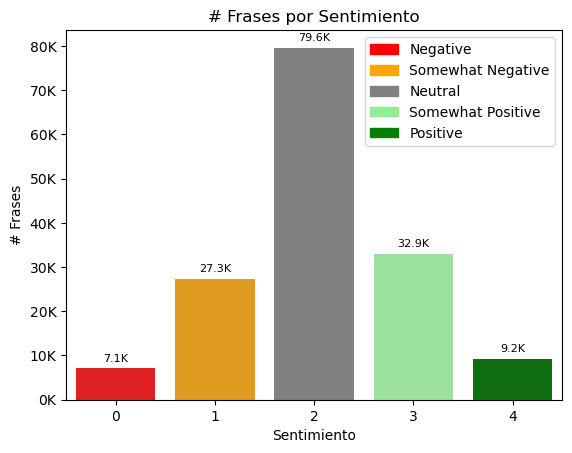

In [44]:

def format_thousands(x, pos):
    return f'{int(x/1000)}K'

# Definir los colores para cada sentimiento
colors = {0: 'red', 1: 'orange', 2: 'gray', 3: 'lightgreen', 4: 'green'}


sentiment_counts = criticas['Sentiment'].value_counts().sort_index()

# Crear el gráfico de barras
ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=colors.values())

# Títulos y etiquetas
plt.title('# Frases por Sentimiento')
plt.xlabel('Sentimiento')
plt.ylabel('# Frases')

# Añadir leyenda personalizada
labels = ['Negative', 'Somewhat Negative', 'Neutral', 'Somewhat Positive', 'Positive']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in colors.keys()]
plt.legend(handles, labels)

# Añadir etiquetas de valores 
for p in ax.patches:
    ax.annotate(f'{p.get_height()/1000:.1f}K', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=8, color='black', xytext=(0, 5), 
                textcoords='offset points')


ax.yaxis.set_major_formatter(FuncFormatter(format_thousands))

# Mostrar gráfico
plt.show()


Se revisa por cada sentimiento el top 10 de palabras más repetidas, así como un wordcloud.
PD. Se elimina stopwords y se lematiza y hace steaming para obtener palabras que podrían aportar significado, ya que si no se lo hace, las stopwords son las que primero aparecen en nuestro ranking de cada sentimiento 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DETPC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DETPC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\DETPC\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
c:\Users\DETPC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


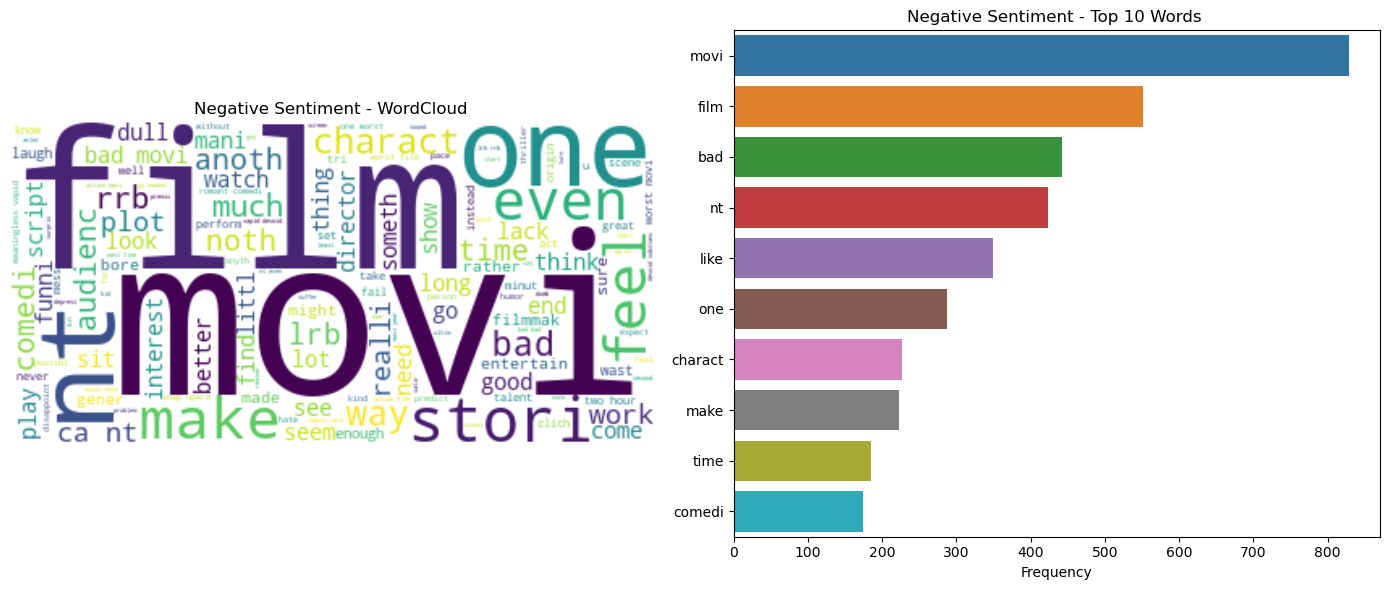

c:\Users\DETPC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


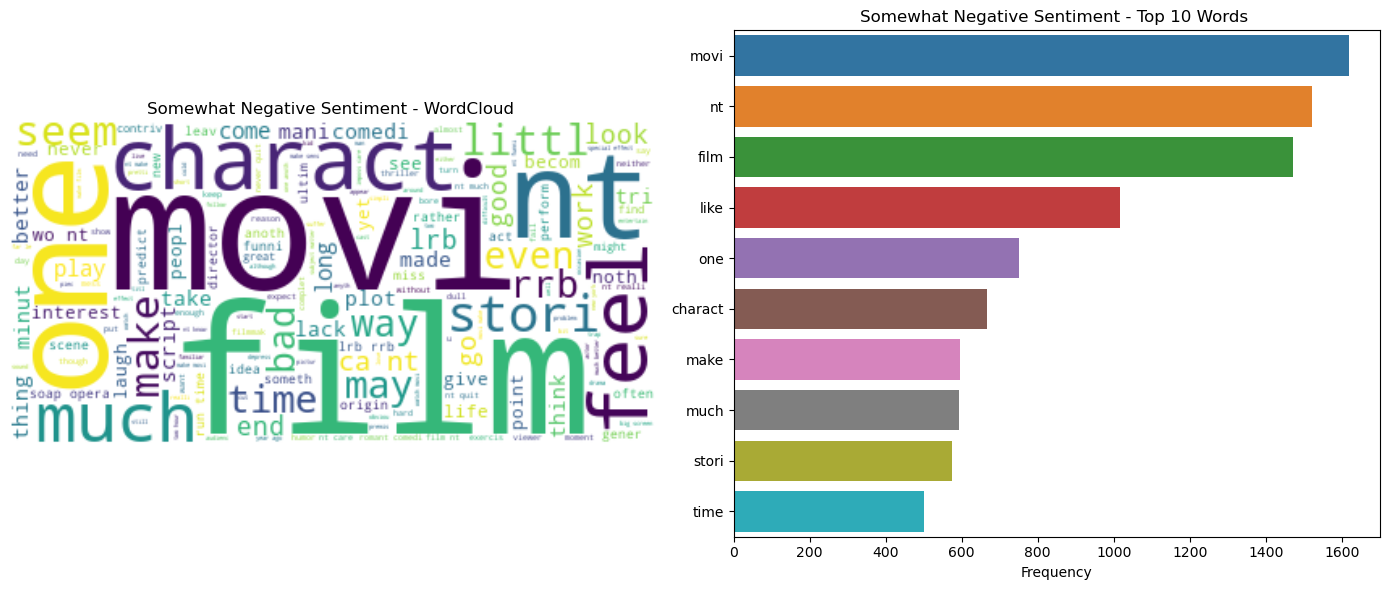

c:\Users\DETPC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


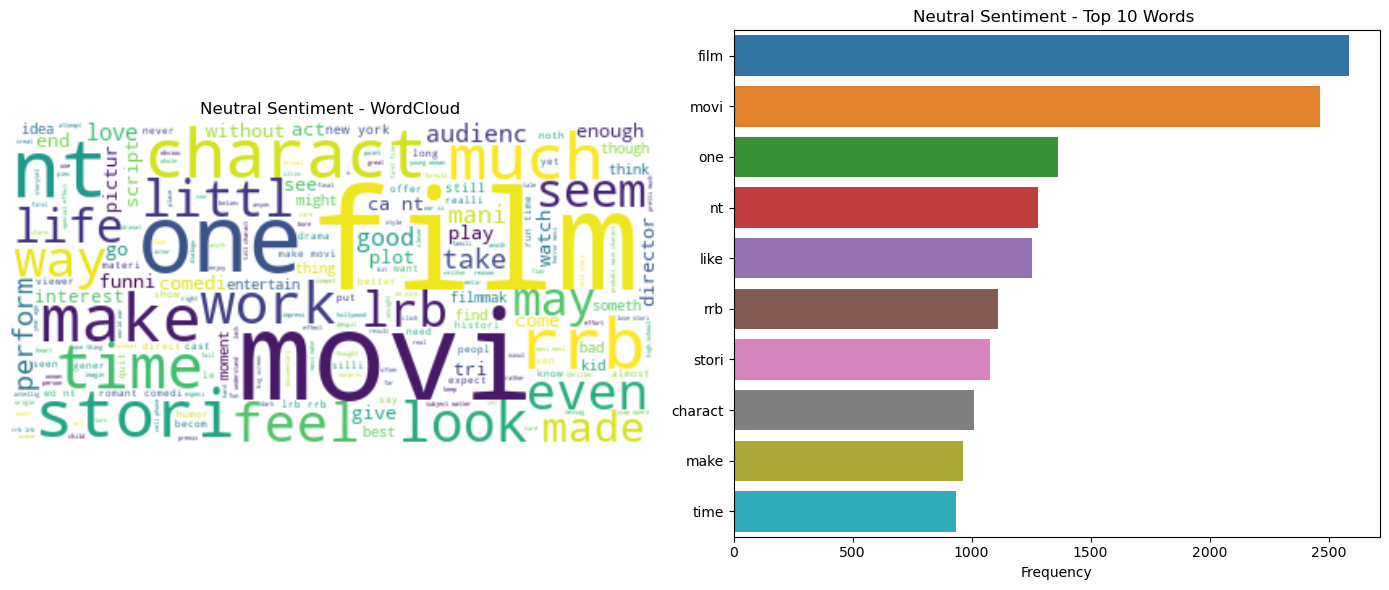

c:\Users\DETPC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


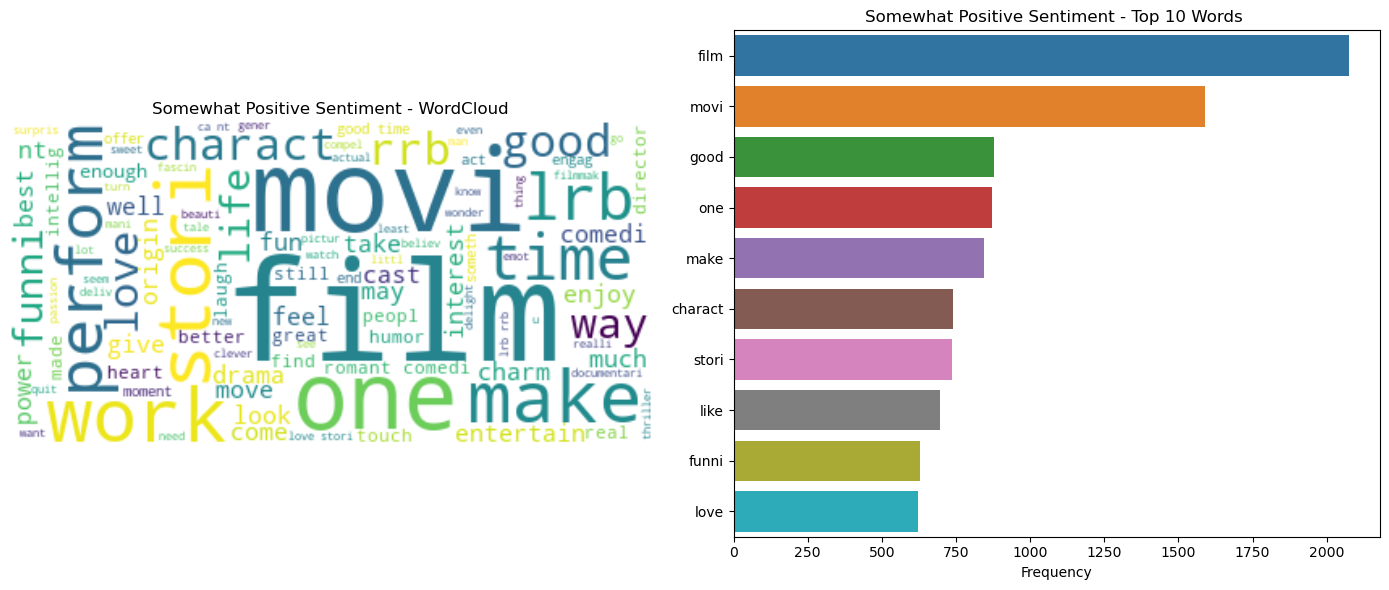

c:\Users\DETPC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


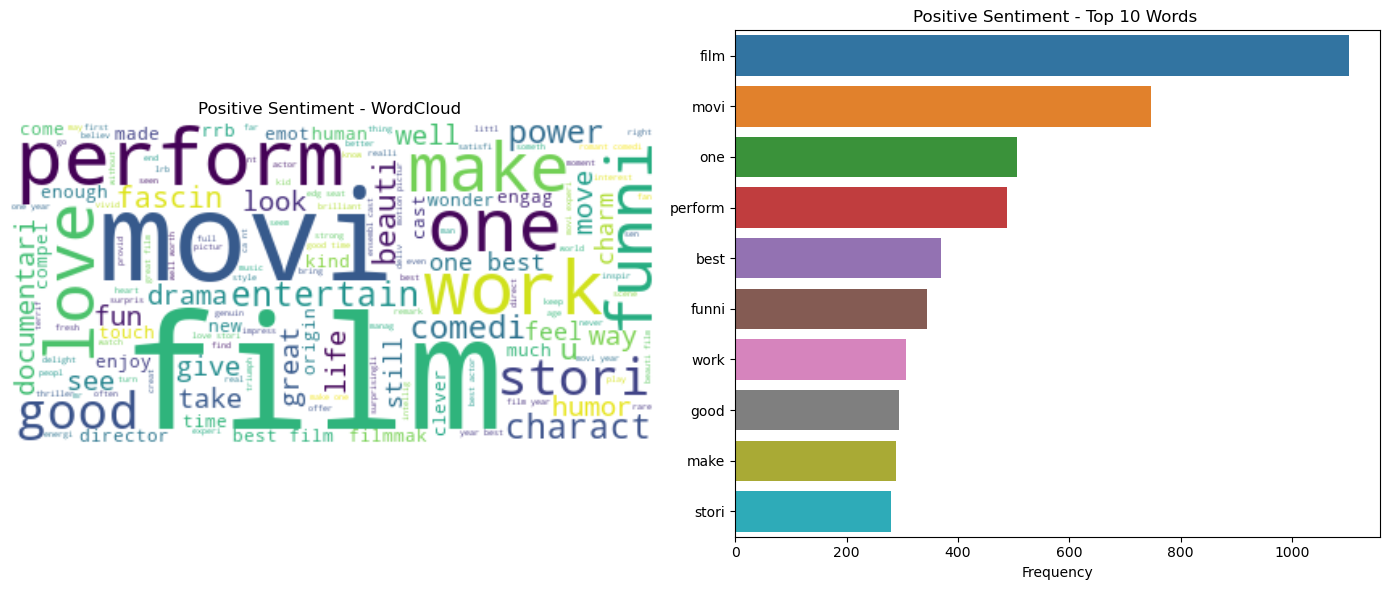

In [45]:
# Definir stopwords
stop_words = set(stopwords.words('english'))

# Inicializar lematizador y stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Función para tokenizar, eliminar puntuación, stopwords, aplicar lematización y stemming
def preprocess_text(text):
    # Eliminar signos de puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenizar y aplicar preprocesamiento
    tokens = [word for word in text.split() if word.lower() not in stop_words]
    tokens_lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    tokens_stemmed = [stemmer.stem(token) for token in tokens_lemmatized]
    
    # Retornar solo si hay tokens restantes después del procesamiento
    return tokens_stemmed if tokens_stemmed else None

# Aplicar el preprocesamiento
criticas['Tokens_clean'] = criticas['Phrase'].apply(preprocess_text)

# Eliminar filas con valores nulos resultantes del preprocesamiento
criticas = criticas.dropna(subset=['Tokens_clean'])

# Función para generar WordCloud y gráfico de barras eliminando stopwords
def plot_wordcloud_and_barchart_clean(data, sentiment_value, title):
    # Filtrar datos por sentimiento
    tokens = data[data['Sentiment'] == sentiment_value]['Tokens_clean'].sum()
    
    # Contar las palabras más frecuentes
    word_counts = Counter(tokens)
    most_common_words = word_counts.most_common(10)
    
    # Crear WordCloud
    wordcloud = WordCloud(background_color='white').generate(' '.join(tokens))
    
    # Crear subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # Subplot 1: WordCloud
    axs[0].imshow(wordcloud, interpolation='bilinear')
    axs[0].axis('off')
    axs[0].set_title(f'{title} - WordCloud ')
    
    # Subplot 2: Gráfico de barras de las 10 palabras más comunes
    words, counts = zip(*most_common_words)
    sns.barplot(x=list(counts), y=list(words), ax=axs[1])
    axs[1].set_title(f'{title} - Top 10 Words ')
    axs[1].set_xlabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Generar gráficos para cada sentimiento con stopwords eliminadas y lematización/steeming aplicados
plot_wordcloud_and_barchart_clean(criticas, 0, 'Negative Sentiment')
plot_wordcloud_and_barchart_clean(criticas, 1, 'Somewhat Negative Sentiment')
plot_wordcloud_and_barchart_clean(criticas, 2, 'Neutral Sentiment')
plot_wordcloud_and_barchart_clean(criticas, 3, 'Somewhat Positive Sentiment')
plot_wordcloud_and_barchart_clean(criticas, 4, 'Positive Sentiment')


Se observa que aparecen palabras caracteristicas de cada sentimiento como good, fun en positivas y bad en negativas.

Tokenizamos, realizamos el bag of words sin preprocesar más y realizamos el entrenamiento y test

In [10]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Tokenización básica (sin eliminar stopwords ni aplicar técnicas adicionales)
criticas['Text_basic'] = criticas['Phrase']

# Usar CountVectorizer para crear el Bag of Words sin ningún preprocesamiento adicional
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(criticas['Text_basic'])

# Asignar la variable objetivo
y = criticas['Sentiment']

# Separar en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir y entrenar el modelo Naive Bayes
model = MultinomialNB()
model.fit(X_train, y_train)

# Predecir y evaluar el modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

Accuracy: 0.6080193236714976
              precision    recall  f1-score   support

           0       0.43      0.30      0.35      1442
           1       0.49      0.45      0.47      5444
           2       0.70      0.77      0.73     15744
           3       0.52      0.50      0.51      6585
           4       0.45      0.31      0.37      1835

    accuracy                           0.61     31050
   macro avg       0.52      0.47      0.49     31050
weighted avg       0.60      0.61      0.60     31050



Realizamos el mismo proceso pero ahora quitando las stopwords, lematizando y haciendo el stemming

In [24]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import string

# Descargar recursos de NLTK si no lo has hecho
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Definir stopwords y preprocesadores
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Función para preprocesar el texto
def preprocess_text(text):
    # Eliminar signos de puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    tokens = [word for word in text.split() if word.lower() not in stop_words]
    tokens_lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    tokens_stemmed = [stemmer.stem(token) for token in tokens_lemmatized]
    # Retornar solo si hay tokens restantes después del procesamiento
    return ' '.join(tokens_stemmed) if tokens_stemmed else None

# Aplicar el preprocesamiento
criticas['Text_processed'] = criticas['Phrase'].apply(preprocess_text)

# Eliminar filas con valores nulos resultantes del preprocesamiento
criticas = criticas.dropna(subset=['Text_processed'])

# Usar CountVectorizer para crear el Bag of Words con preprocesamiento aplicado
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(criticas['Text_processed'])

# Asignar la variable objetivo
y = criticas['Sentiment']

# Separar en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir y entrenar el modelo Naive Bayes
model = MultinomialNB()
model.fit(X_train, y_train)

# Predecir y evaluar el modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy after preprocessing: {accuracy}')
print(classification_report(y_test, y_pred))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DETPC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DETPC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\DETPC\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Accuracy after preprocessing: 0.6076754244399974
              precision    recall  f1-score   support

           0       0.46      0.27      0.34      1418
           1       0.49      0.42      0.46      5387
           2       0.68      0.79      0.73     15907
           3       0.51      0.48      0.49      6522
           4       0.46      0.28      0.35      1748

    accuracy                           0.61     30982
   macro avg       0.52      0.45      0.47     30982
weighted avg       0.59      0.61      0.59     30982



Se obtiene el mismo resultado, ya que no estamos como analizando la frecuencia y el impacto de cada palabra por sentimiento, además dle desbalanceo que existe entre los sentimientos

In [25]:
# Calcular estadísticas iniciales sin preprocesamiento
total_phrases_before = criticas.shape[0]
total_words_before = criticas['Phrase'].apply(lambda x: len(x.split())).sum()

# Número de frases y palabras por sentimiento sin preprocesamiento
phrases_per_sentiment_before = criticas.groupby('Sentiment')['Phrase'].count()
words_per_sentiment_before = criticas.groupby('Sentiment')['Phrase'].apply(lambda x: x.apply(lambda y: len(y.split())).sum())

# Función para preprocesar el texto (quitando signos de puntuación)
def preprocess_text(text):
    # Eliminar signos de puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenizar, eliminar stopwords, lematizar y aplicar stemming
    tokens = [word for word in text.split() if word.lower() not in stop_words]
    tokens_lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    tokens_stemmed = [stemmer.stem(token) for token in tokens_lemmatized]
    
    return ' '.join(tokens_stemmed) if tokens_stemmed else None

# Aplicar el preprocesamiento
criticas['Text_processed'] = criticas['Phrase'].apply(preprocess_text)

# Eliminar filas con valores nulos después del preprocesamiento
criticas_processed = criticas.dropna(subset=['Text_processed'])

# Calcular estadísticas con preprocesamiento
total_phrases_after = criticas_processed.shape[0]
total_words_after = criticas_processed['Text_processed'].apply(lambda x: len(x.split())).sum()

# Número de frases y palabras por sentimiento con preprocesamiento
phrases_per_sentiment_after = criticas_processed.groupby('Sentiment')['Text_processed'].count()
words_per_sentiment_after = criticas_processed.groupby('Sentiment')['Text_processed'].apply(lambda x: x.apply(lambda y: len(y.split())).sum())

# Crear un DataFrame comparativo
comparison_df = pd.DataFrame({
    'Total Frases (Sin Preprocesamiento)': [total_phrases_before],
    'Total Frases (Con Preprocesamiento)': [total_phrases_after],
    'Total Palabras (Sin Preprocesamiento)': [total_words_before],
    'Total Palabras (Con Preprocesamiento)': [total_words_after]
})

comparison_per_sentiment = pd.DataFrame({
    'Frases por Sentimiento (Sin Preprocesamiento)': phrases_per_sentiment_before,
    'Frases por Sentimiento (Con Preprocesamiento)': phrases_per_sentiment_after,
    'Palabras por Sentimiento (Sin Preprocesamiento)': words_per_sentiment_before,
    'Palabras por Sentimiento (Con Preprocesamiento)': words_per_sentiment_after
})

A pesar que los resultados no varian entre los dos modelos, lo que si mejora es el tamaño dle dataset al aplicar y quitar stopwords ya que esto hace que la cantidad a procesar sea menor y mejora la eficiencia de computo.

In [26]:
comparison_df.head()


,Total Frases (Sin Preprocesamiento),Total Frases (Con Preprocesamiento),Total Palabras (Sin Preprocesamiento),Total Palabras (Con Preprocesamiento)
0,154906,154906,1121351,614503


In [27]:
comparison_per_sentiment.head()

,Frases por Sentimiento (Sin Preprocesamiento),Frases por Sentimiento (Con Preprocesamiento),Palabras por Sentimiento (Sin Preprocesamiento),Palabras por Sentimiento (Con Preprocesamiento)
Sentiment,,,,
0,7072,7072,85609,44334
1,27245,27245,248443,132592
2,78518,78518,410844,232261
3,32865,32865,277938,151936
4,9206,9206,98517,53380


Para probar si el desbalanceo afecta demasiado, lo que se hace es bajar la cantidad de sentimientos, de 5 a 3, los dos sentimientos buenos se convierten en uno y los dos de negativos en uno de igual manera.

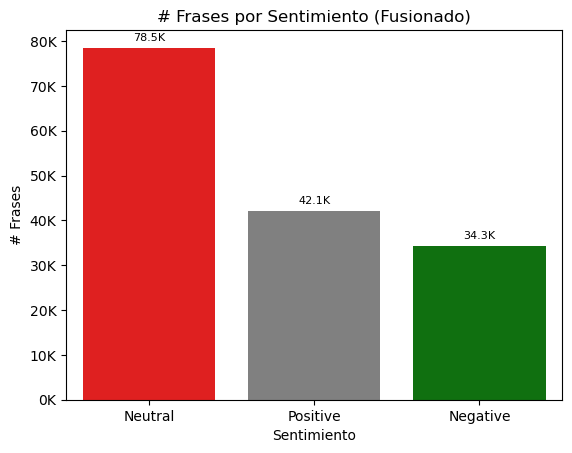

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Fusionar los sentimientos 0 y 1 como 'Negative', 2 como 'Neutral', y 3 y 4 como 'Positive'
criticas_processed['Sentiment_Merged'] = criticas_processed['Sentiment'].replace({0: 'Negative', 1: 'Negative', 2: 'Neutral', 3: 'Positive', 4: 'Positive'})

# Contar los valores de 'Sentiment_Merged'
sentiment_counts_merged = criticas_processed['Sentiment_Merged'].value_counts()

# Crear el gráfico de barras con la nueva distribución de sentimientos
colors_merged = {'Negative': 'red', 'Neutral': 'gray', 'Positive': 'green'}
ax = sns.barplot(x=sentiment_counts_merged.index, y=sentiment_counts_merged.values, palette=colors_merged.values())

# Títulos y etiquetas
plt.title('# Frases por Sentimiento (Fusionado)')
plt.xlabel('Sentimiento')
plt.ylabel('# Frases')

# Añadir etiquetas de valores en las barras, con formato de miles (K)
for p in ax.patches:
    ax.annotate(f'{p.get_height()/1000:.1f}K', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=8, color='black', xytext=(0, 5), 
                textcoords='offset points')

# Formatear los ejes Y para mostrar valores en miles (K)
ax.yaxis.set_major_formatter(FuncFormatter(format_thousands))

# Mostrar gráfico
plt.show()


In [29]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import string

# Descargar recursos de NLTK si no lo has hecho
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Definir stopwords y preprocesadores
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Función para preprocesar el texto
def preprocess_text(text):
    # Eliminar signos de puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    tokens = [word for word in text.split() if word.lower() not in stop_words]
    tokens_lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    tokens_stemmed = [stemmer.stem(token) for token in tokens_lemmatized]
    # Retornar solo si hay tokens restantes después del procesamiento
    return ' '.join(tokens_stemmed) if tokens_stemmed else None

# Aplicar el preprocesamiento
criticas['Text_processed'] = criticas['Phrase'].apply(preprocess_text)

# Eliminar filas con valores nulos resultantes del preprocesamiento
criticas = criticas.dropna(subset=['Text_processed'])

# Fusionar los sentimientos 0 y 1 como 'Negative', 2 como 'Neutral', y 3 y 4 como 'Positive'
criticas['Sentiment_Merged'] = criticas['Sentiment'].replace({0: 'Negative', 1: 'Negative', 2: 'Neutral', 3: 'Positive', 4: 'Positive'})

# Usar CountVectorizer para crear el Bag of Words con preprocesamiento aplicado
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(criticas['Text_processed'])

# Asignar la variable objetivo con los sentimientos fusionados
y = criticas['Sentiment_Merged']

# Separar en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir y entrenar el modelo Naive Bayes
model = MultinomialNB()
model.fit(X_train, y_train)

# Predecir y evaluar el modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy after preprocessing with merged sentiments: {accuracy}')
print(classification_report(y_test, y_pred))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DETPC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DETPC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\DETPC\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Accuracy after preprocessing with merged sentiments: 0.6801691304628494
              precision    recall  f1-score   support

    Negative       0.65      0.59      0.62      6805
     Neutral       0.70      0.73      0.72     15907
    Positive       0.66      0.65      0.66      8270

    accuracy                           0.68     30982
   macro avg       0.67      0.66      0.66     30982
weighted avg       0.68      0.68      0.68     30982



Podemos observar una ligera mejora en el accuracy al tratar un poco de balancear los datos, pero igual el impacto no es tan grande.

De igual manera realizamos un EDA de cada sentimiento, y al igual que el analisis anterior, vemos que en sentimientos positivos aparecen palabras como good o fun, y en negativos como Bad

c:\Users\DETPC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


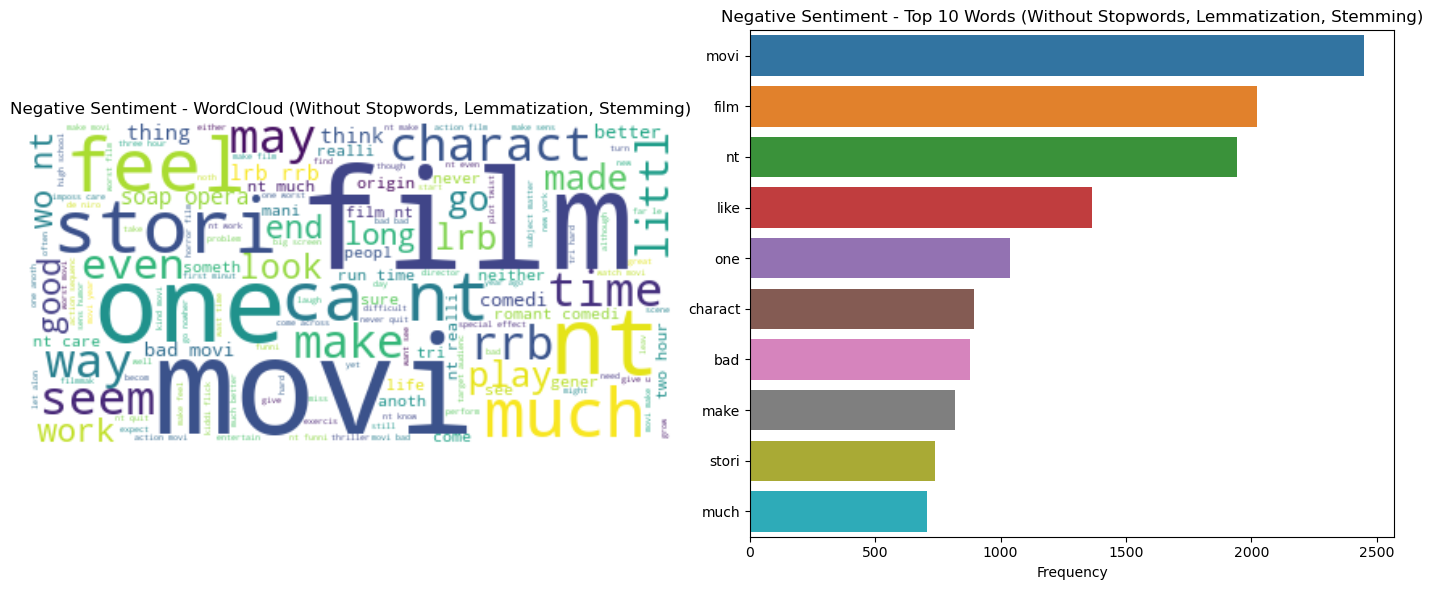

c:\Users\DETPC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


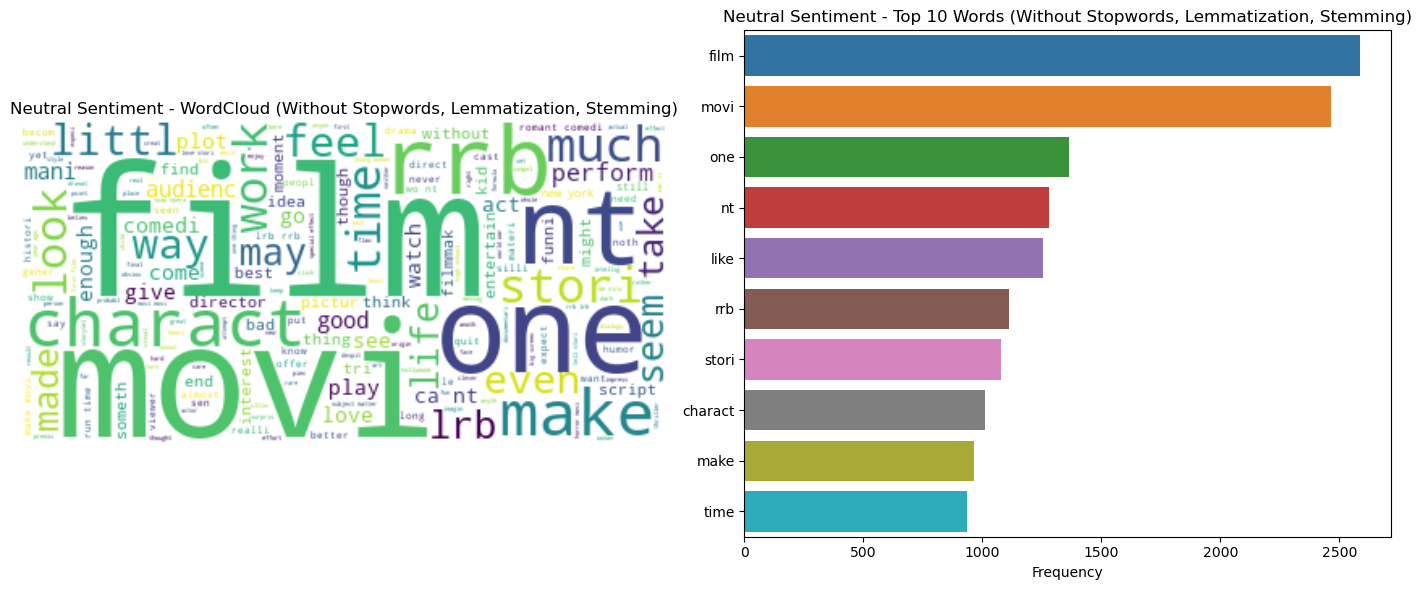

c:\Users\DETPC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


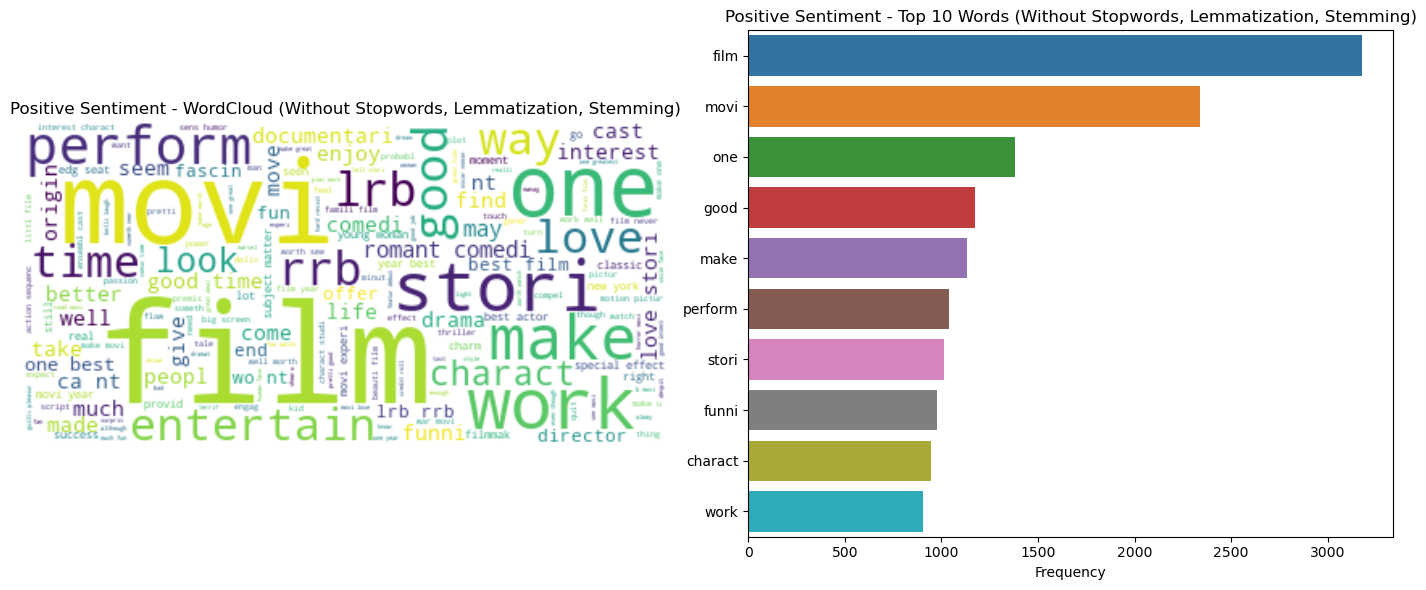

In [22]:
import string

# Función para tokenizar, eliminar stopwords, aplicar lematización y stemming
def preprocess_text(text):
    # Eliminar signos de puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenizar, eliminar stopwords, lematizar y aplicar stemming
    tokens = [word for word in text.split() if word.lower() not in stop_words]
    tokens_lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    tokens_stemmed = [stemmer.stem(token) for token in tokens_lemmatized]
    
    # Retornar solo si hay tokens restantes después del procesamiento
    return tokens_stemmed if tokens_stemmed else None

# Función para fusionar los sentimientos
def merge_sentiments(sentiment):
    if sentiment in [0, 1]:
        return 'Negative'
    elif sentiment == 2:
        return 'Neutral'
    elif sentiment in [3, 4]:
        return 'Positive'

# Aplicar la fusión de sentimientos en el dataset
criticas['Sentiment_Merged'] = criticas['Sentiment'].apply(merge_sentiments)

# Aplicar el preprocesamiento
criticas['Tokens_clean'] = criticas['Phrase'].apply(preprocess_text)

# Eliminar filas con valores nulos resultantes del preprocesamiento
criticas = criticas.dropna(subset=['Tokens_clean'])

# Función para generar WordCloud y gráfico de barras para los sentimientos fusionados
def plot_wordcloud_and_barchart_clean_merged(data, sentiment_value, title):
    # Filtrar datos por sentimiento
    tokens = data[data['Sentiment_Merged'] == sentiment_value]['Tokens_clean'].sum()
    
    # Contar las palabras más frecuentes
    word_counts = Counter(tokens)
    most_common_words = word_counts.most_common(10)
    
    # Crear WordCloud
    wordcloud = WordCloud(background_color='white').generate(' '.join(tokens))
    
    # Crear subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # Subplot 1: WordCloud
    axs[0].imshow(wordcloud, interpolation='bilinear')
    axs[0].axis('off')
    axs[0].set_title(f'{title} - WordCloud (Without Stopwords, Lemmatization, Stemming)')
    
    # Subplot 2: Gráfico de barras de las 10 palabras más comunes
    words, counts = zip(*most_common_words)
    sns.barplot(x=list(counts), y=list(words), ax=axs[1])
    axs[1].set_title(f'{title} - Top 10 Words (Without Stopwords, Lemmatization, Stemming)')
    axs[1].set_xlabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Generar gráficos para los 3 sentimientos fusionados
plot_wordcloud_and_barchart_clean_merged(criticas, 'Negative', 'Negative Sentiment')
plot_wordcloud_and_barchart_clean_merged(criticas, 'Neutral', 'Neutral Sentiment')
plot_wordcloud_and_barchart_clean_merged(criticas, 'Positive', 'Positive Sentiment')


Realizo el mismo proceso usando ahora IF-IDF

In [30]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string

# Descargar recursos de NLTK si no lo has hecho
nltk.download('stopwords')
nltk.download('wordnet')

# Definir stopwords y preprocesadores
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Función para preprocesar el texto
def preprocess_text(text):
    # Eliminar signos de puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenizar, eliminar stopwords, lematizar y aplicar stemming
    tokens = [word for word in text.split() if word.lower() not in stop_words]
    tokens_lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    tokens_stemmed = [stemmer.stem(token) for token in tokens_lemmatized]
    
    # Unir tokens nuevamente en una cadena de texto
    return ' '.join(tokens_stemmed) if tokens_stemmed else None

# Aplicar el preprocesamiento
criticas['Text_processed'] = criticas['Phrase'].apply(preprocess_text)

# Eliminar filas con valores nulos resultantes del preprocesamiento
criticas = criticas.dropna(subset=['Text_processed'])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DETPC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DETPC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Crear una instancia de TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Aplicar TF-IDF al texto preprocesado
X_tfidf = tfidf_vectorizer.fit_transform(criticas['Text_processed'])

# Visualizar la forma de la matriz TF-IDF
print("Shape of TF-IDF matrix:", X_tfidf.shape)


Shape of TF-IDF matrix: (154906, 11851)


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Asignar la variable objetivo (sentimientos fusionados)
y = criticas['Sentiment_Merged']

# Separar en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Definir y entrenar el modelo Naive Bayes
model = MultinomialNB()
model.fit(X_train, y_train)

# Predecir y evaluar el modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy after TF-IDF and classification: {accuracy}')
print(classification_report(y_test, y_pred))


Accuracy after TF-IDF and classification: 0.6661932735136531
              precision    recall  f1-score   support

    Negative       0.70      0.43      0.53      6805
     Neutral       0.65      0.83      0.73     15907
    Positive       0.70      0.55      0.62      8270

    accuracy                           0.67     30982
   macro avg       0.68      0.60      0.63     30982
weighted avg       0.67      0.67      0.65     30982



Vemos que no mejora al usar TF IDF podría ser porque Naive Bayes asume que las características (palabras) son condicionalmente independientes dado el sentimiento, y los pesos de TF-IDF podrían no alinear bien con esta suposición.

In [41]:
# Obtener los nombres de las características (palabras)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Crear una función para obtener las mejores palabras para cada sentimiento
def get_top_tfidf_words_for_sentiment(X_tfidf, data, sentiment_value, sentiment_name, top_n=10):
    # Obtener los índices de las filas que corresponden al sentimiento específico
    sentiment_indices = np.where(data['Sentiment_Merged'] == sentiment_value)[0]
    
    # Extraer las filas correspondientes al sentimiento
    X_sentiment = X_tfidf[sentiment_indices]
    
    # Calcular el promedio de TF-IDF para cada palabra en este sentimiento
    tfidf_means = X_sentiment.mean(axis=0).A1  # Convertir a arreglo unidimensional
    
    # Crear un DataFrame con las palabras y sus puntuaciones TF-IDF
    tfidf_df = pd.DataFrame({'word': feature_names, 'tfidf_score': tfidf_means})
    
    # Ordenar el DataFrame por la puntuación de TF-IDF y seleccionar las top_n palabras
    top_words = tfidf_df.sort_values(by='tfidf_score', ascending=False).head(top_n)
    
    print(f"Top {top_n} words for {sentiment_name} sentiment:")
    print(top_words)
    print("\n")

# Obtener las 10 mejores palabras por cada sentimiento
get_top_tfidf_words_for_sentiment(X_tfidf, criticas, 'Negative', 'Negative')
get_top_tfidf_words_for_sentiment(X_tfidf, criticas, 'Neutral', 'Neutral')
get_top_tfidf_words_for_sentiment(X_tfidf, criticas, 'Positive', 'Positive')


Top 10 words for Negative sentiment:
         word  tfidf_score
6755     movi     0.016886
7087       nt     0.015670
3797     film     0.012722
853       bad     0.010210
6019     like     0.009417
7193      one     0.007813
1769  charact     0.006946
6771     much     0.006412
6277     make     0.006055
9930    stori     0.005998


Top 10 words for Neutral sentiment:
          word  tfidf_score
6755      movi     0.010896
3797      film     0.010714
7193       one     0.006236
7087        nt     0.005372
9930     stori     0.005347
6019      like     0.005256
1769   charact     0.005242
10521     time     0.005028
8726       rrb     0.004854
6277      make     0.004524


Top 10 words for Positive sentiment:
         word  tfidf_score
3797     film     0.018276
6755     movi     0.014660
4361     good     0.011133
4126    funni     0.009666
7193      one     0.009040
7590  perform     0.008727
6150     love     0.007938
1072     best     0.007598
9930    stori     0.007319
6277     ma